# Introduction

This Jupyter Notebook demonstrates the process of building and evaluating a deep learning model for audio digits classification using TensorFlow and Keras. The workflow includes:

- **Data Preparation**: Loading and preprocessing audio data.
- **Data Visualization**: Plotting waveforms and spectrograms.
- **Model Building**: Creating a convolutional neural network (CNN) model.
- **Model Training**: Training the model with the training dataset.
- **Model Evaluation**: Evaluating the model's performance on the test dataset.
- **Model Interpretation**: Using SHAP to interpret the model's predictions.
- **Model Saving**: Saving the trained model and its weights.

The notebook also includes various visualizations to help understand the data and the model's performance.

In [1]:
import os
import importlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.layers import Normalization, Resizing
from keras import layers
from keras import models
from IPython import display

from funcs import *

import funcs
importlib.reload(funcs)

# Set TensorFlow to allow GPU memory growth
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-01-25 12:36:01.258852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check Hardware Accelerator

In [2]:
# Check number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2025-01-25 12:36:04.218896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-25 12:36:04.271199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-25 12:36:04.271475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Load Train, Validation and Test filenames

In [3]:
# Get a list of all filenames in the data directory and shuffle them
def get_filenames(data_dir):
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    return filenames

# Get the total number of samples
train_filenames = get_filenames('data_split/train')
val_filenames = get_filenames('data_split/val')
test_filenames = get_filenames('data_split/test')

num_samples = len(train_filenames) + len(val_filenames) + len(test_filenames)

# Print the number of samples and an example filename
print('Number of all samples: ', num_samples)
print('Example filename: ', train_filenames[0])

# Print the sizes of each set
print('Training set size', len(train_filenames))
print('Validation set size', len(val_filenames))
print('Test set size', len(test_filenames))

Number of all samples:  30000
Example filename:  tf.Tensor(b'data_split/train/37/4_37_34.wav', shape=(), dtype=string)
Training set size 18000
Validation set size 6000
Test set size 6000


2025-01-25 12:36:04.364113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-25 12:36:04.364428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-25 12:36:04.364654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Load data with labels

In [4]:
# Set AUTOTUNE for optimizing data loading
AUTOTUNE = tf.data.AUTOTUNE

# Create a dataset from the training file paths
files_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

# Map the file paths to their corresponding waveforms and labels
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

### Visualize audio waveforms

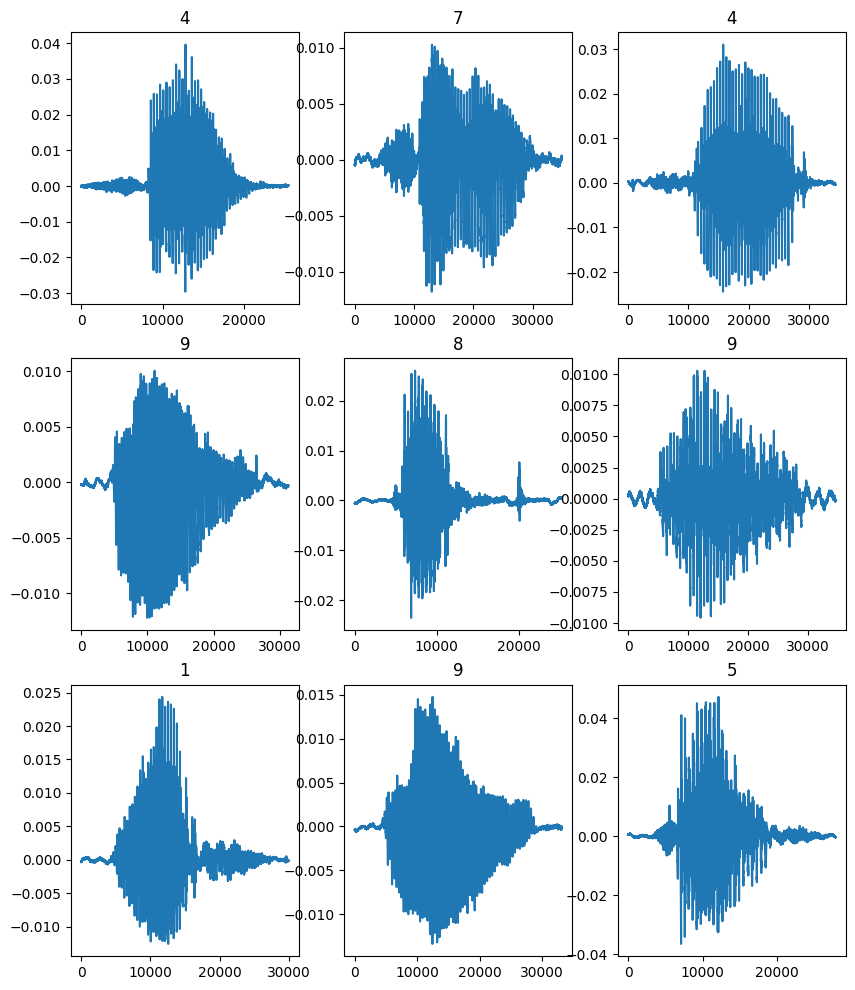

In [5]:
# Define the number of rows and columns for the plot grid
rows = 3
cols = 3
n = rows * cols

# Create a figure with a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

# Iterate over the first 'n' waveforms and their labels in the dataset
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols  # Determine the row index
    c = i % cols   # Determine the column index
    ax = axes[r][c]  # Get the corresponding subplot axis
    ax.plot(audio.numpy())  # Plot the audio waveform
    label = label.numpy().decode('utf-8')  # Decode the label from bytes to string
    ax.set_title(str(label))  # Set the title of the subplot to the label

# Display the plot
plt.show()

### Visualize example audio waveform with corespoinding spectrogram

Label: 4


/workspaces/audio-mnist/funcs.py:67: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


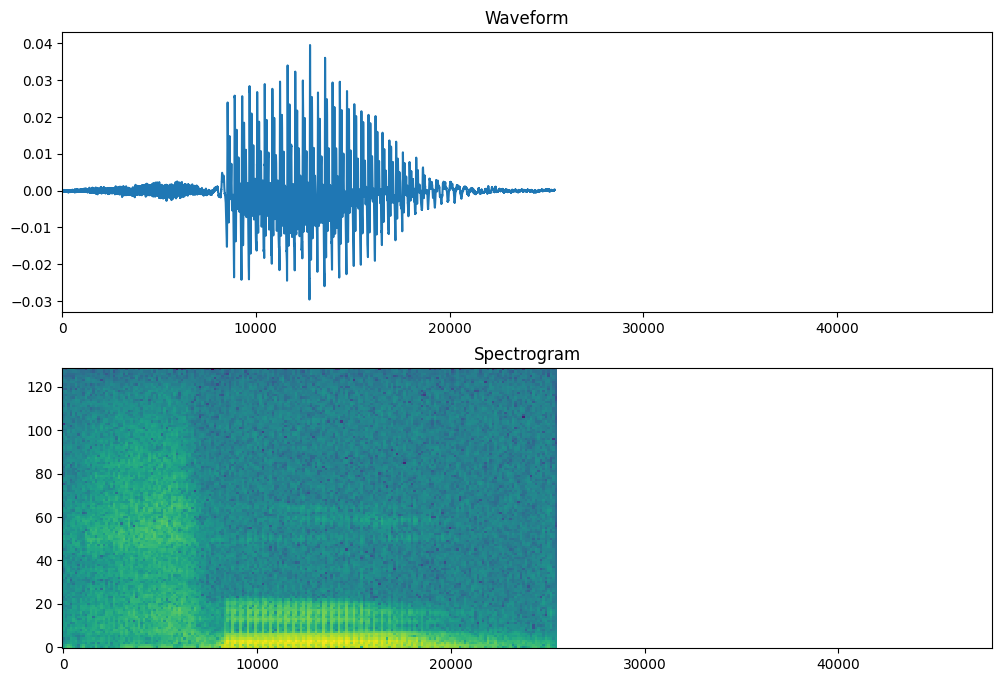

In [6]:
# Take one example from the waveform dataset
for waveform, label in waveform_ds.take(1):
    # Decode the label from bytes to string
    label = label.numpy().decode('utf-8')
    # Generate the spectrogram for the waveform
    spectrogram = get_spectrogram(waveform)

# Print the label of the example
print('Label:', label)

# Create a figure with 2 subplots
fig, axes = plt.subplots(2, figsize=(12, 8))

# Create a timescale for the waveform
timescale = np.arange(waveform.shape[0])

# Plot the waveform on the first subplot
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

# Plot the spectrogram on the second subplot
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

# Display the plot
plt.show()

### Visualize multiple audio spectograms with corresponding labels

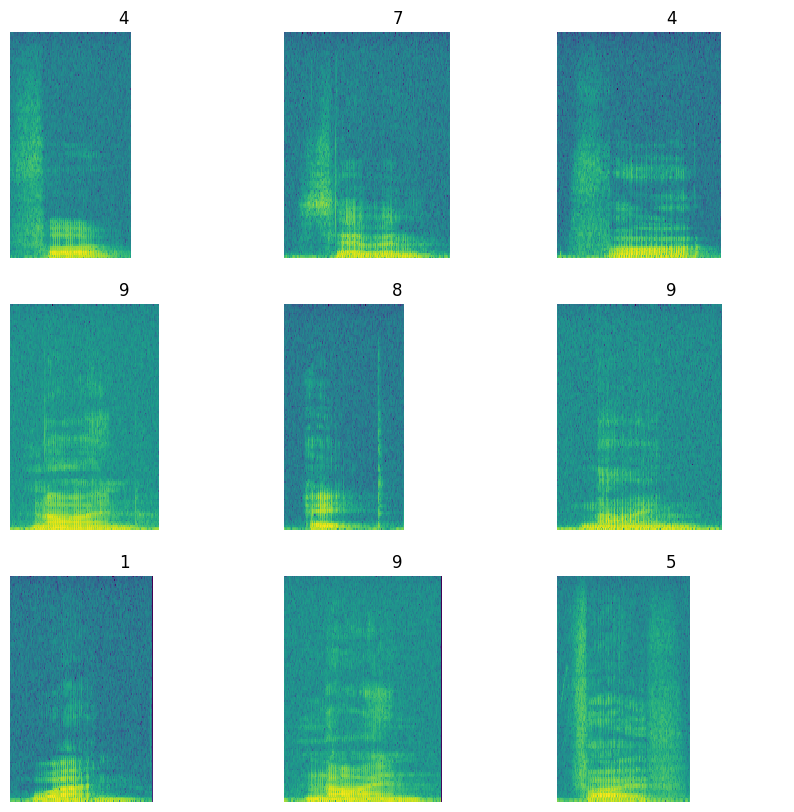

In [7]:
# Map the waveforms to their corresponding spectrograms and label IDs
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Iterate over the first 'n' spectrograms and their label IDs in the dataset
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)  # Plot the spectrogram
    ax.set_title(str(label_id.numpy()))  # Set the title of the subplot to the label ID
    ax.axis('off')  # Turn off the axis

plt.show()

### Preprocess data for the model

In [8]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_filenames)
test_ds = preprocess_dataset(test_filenames)

### Create Train and Validation datasets

In [9]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### Build the CNN model

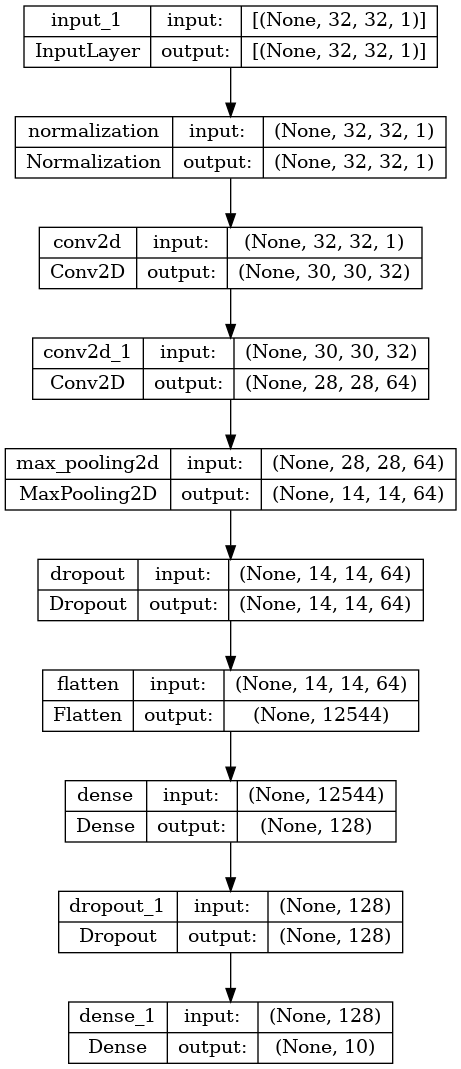

In [10]:
num_labels = 10

# Create a normalization layer and adapt it to the spectrogram dataset
norm_layer = Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Build the CNN model
model = models.Sequential([
    layers.Input(shape=(32, 32, 1)),
    # Normalization layer
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the Model

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the Model

In [12]:
# Number of epochs to train the model
EPOCHS = 5

# Function to resize images to 32x32 pixels
def resize_image(image, label):
    image = tf.image.resize(image, [32, 32])
    return image, label

# Apply the resize function to the training, validation, and test datasets
train_ds_map = train_ds.map(resize_image)
val_ds_map = val_ds.map(resize_image)
test_ds_map = test_ds.map(resize_image)

# Train the model with the training dataset and validate with the validation dataset
history = model.fit(
    train_ds_map,
    validation_data=val_ds_map,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),  # Early stopping callback to prevent overfitting
)

Epoch 1/5


2025-01-25 12:36:28.222828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-25 12:36:28.759695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-01-25 12:36:29.638904: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7d4c922b7dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-25 12:36:29.638981: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-01-25 12:36:29.713236: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-25 12:36:30.099684: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

282/282 [==============================] - 20s 57ms/step - loss: 0.6491 - accuracy: 0.8069 - val_loss: 0.2338 - val_accuracy: 0.9308
Epoch 2/5
282/282 [==============================] - 3s 9ms/step - loss: 0.2740 - accuracy: 0.9216 - val_loss: 0.1984 - val_accuracy: 0.9407
Epoch 3/5
282/282 [==============================] - 3s 9ms/step - loss: 0.1848 - accuracy: 0.9507 - val_loss: 0.1460 - val_accuracy: 0.9560
Epoch 4/5
282/282 [==============================] - 2s 8ms/step - loss: 0.1316 - accuracy: 0.9616 - val_loss: 0.1241 - val_accuracy: 0.9593
Epoch 5/5
282/282 [==============================] - 2s 9ms/step - loss: 0.1029 - accuracy: 0.9688 - val_loss: 0.1583 - val_accuracy: 0.9600


### Plot the training vs validation loss per epoch

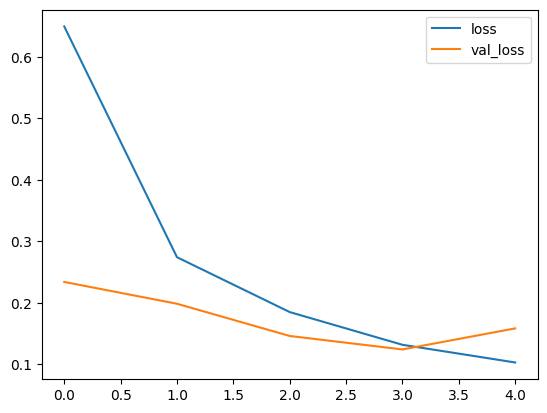

In [13]:
# Extract the metrics from the training history
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Split test dataset to audio and labels

In [14]:
test_audio = []
test_labels = []

for audio, label in test_ds_map:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

### Evaluate the Model

In [15]:
# Predict the labels for the test audio data
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

# Calculate the accuracy of the model on the test dataset
test_acc = sum(y_pred == y_true) / len(y_true)

# Print the test set accuracy
print(f'Test set accuracy: {test_acc:.0%}')

188/188 [==============================] - 0s 2ms/step
Test set accuracy: 95%


### Visualize spectorgram of examples from test dataset with corresponding true and predicted labels

/workspaces/audio-mnist/funcs.py:67: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


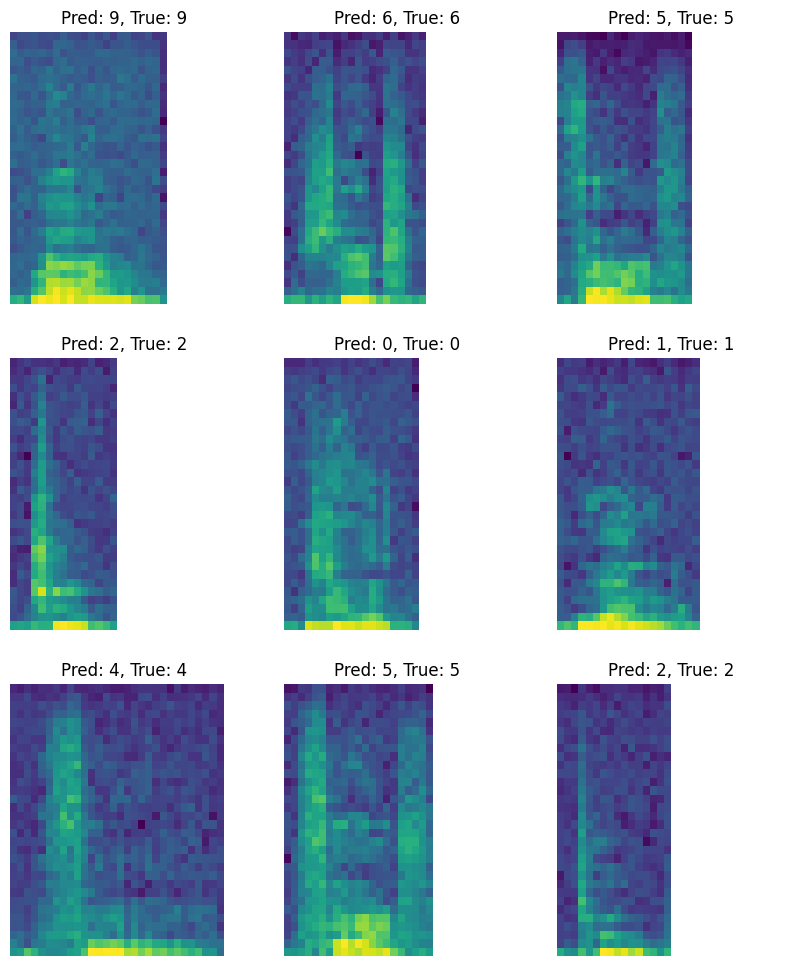

In [16]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(test_audio[i]), ax)
    ax.set_title(f'Pred: {y_pred[i]}, True: {y_true[i]}')
    ax.axis('off')

plt.show()

### Plot confusion matrix

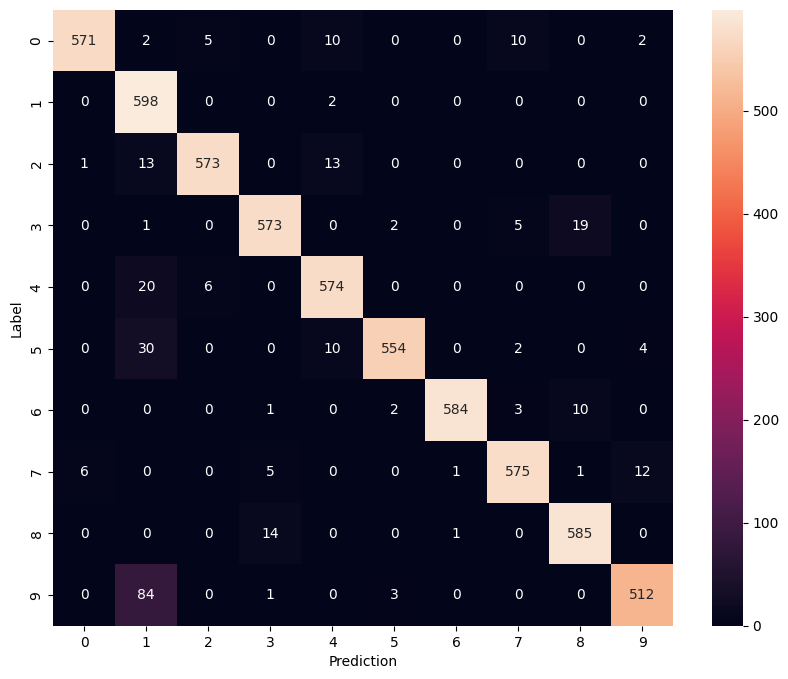

In [17]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Interpret the Model with SHAP

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
divide by zero encountered in log


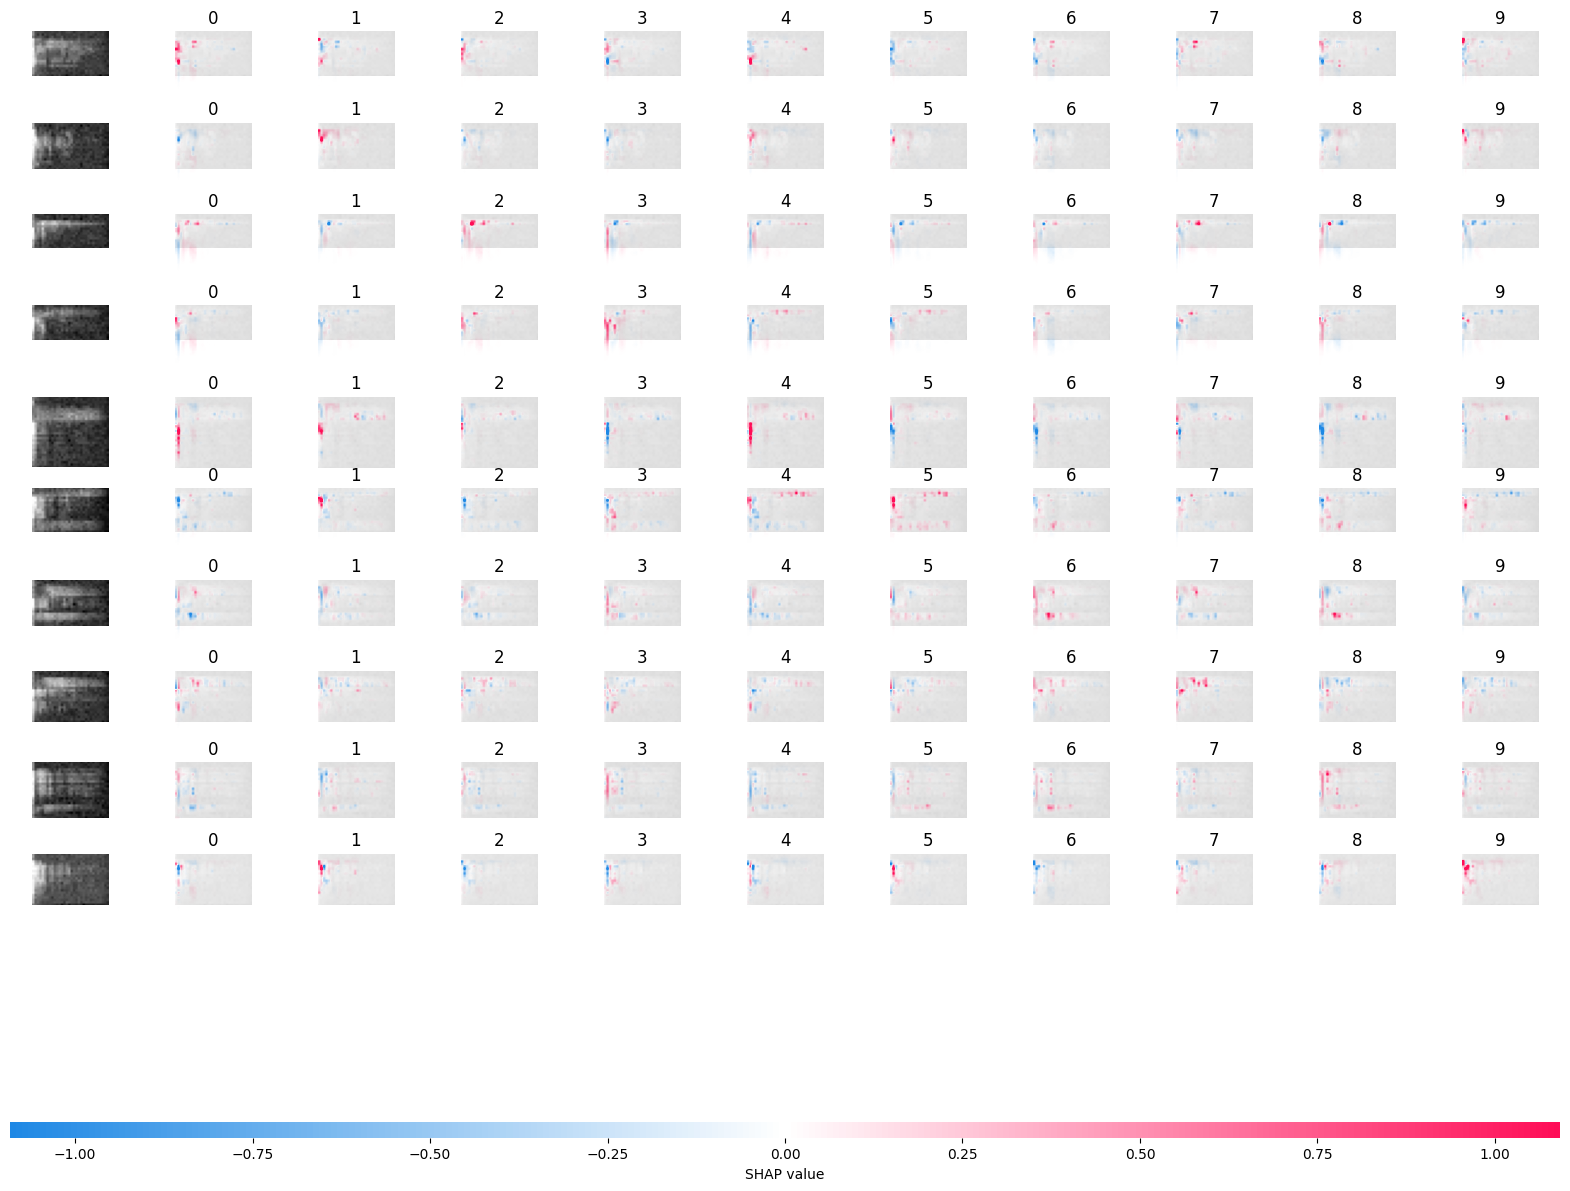

In [18]:
import shap
import numpy as np

# Load the SHAP explainer
explainer = shap.DeepExplainer(model, test_audio[:300])

# Choose a set of instances to explain for each number (0-9)
shap_images = []
for i in range(10):
    # Find the index of the first instance of each label in the test set
    idx = np.where(test_labels == i)[0][0]
    shap_images.append(test_audio[idx])

shap_images = np.array(shap_images)
shap_values = explainer.shap_values(shap_images)

# Apply logarithmic transformation to the SHAP images for better visualization
shap_images = np.array([np.log(x) for x in shap_images])

# Create labels for the SHAP plot
labels = np.tile(np.arange(10), (10, 1))

# Plot the SHAP values
shap.image_plot(shap_values, shap_images, labels=labels)

### Save the model

In [19]:
model.save('saved_models/digits_model.keras')